In [1]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torchvision.transforms import functional as TF
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Image as IPImage
import gc
import matplotlib.colors as mcolors

from wiring_efficiency_utils import *
from neuralsheet import *
from map_plotting import *
from fig_plots import *

In [577]:
5 * (40/17 + 2)

21.764705882352942

In [612]:
# Example usage
crop_size = 20 # Crop size (NxN)
batch_size = 32  # Number of crops to load at once
num_workers = 4  # Number of threads for data loading
root_dir = './input_stimuli'  # Path to your image folder
device = 'cuda'  # Assuming CUDA is available and desired
R_rf = 5
beta = 1 - 5e-5
loss_beta = 1e-2

dataloader = create_dataloader(root_dir, crop_size, batch_size, num_workers)

In [174]:
batch_progress = tqdm(dataloader, leave=False)
inputs = []
for b_idx, batch in enumerate(batch_progress):
    
    inputs.append(batch[:, 0:1].flip(1))

    if b_idx > 100:
        break

inputs = torch.cat(inputs, dim=0)
eff_dim, comp_sampled = get_pca_dimensions(inputs, 3)
print(eff_dim, inputs.shape)

measuring dimensionality, number of Nan found: 0
112 torch.Size([3264, 1, 28, 28])


In [604]:
batch_progress = tqdm(dataloader, leave=False)
codes = []
for b_idx, batch in enumerate(batch_progress):

    for image in batch:
        
        image = image[0:1][None].flip(1).cuda()

        if image.mean() > 0.15:

            model(image, adaptation=False)
            codes.append(model.current_response.clone().cpu())

    if b_idx > 150:
        break

codes = torch.cat(codes, dim=0)
eff_dim, comp_sampled = get_pca_dimensions(codes, 3)
print(eff_dim)

measuring dimensionality, number of Nan found: 0
35


/tmp/ipykernel_13091/2024308994.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t = torch.load('./data_topo_accdim.pt')['reco_tracker'][:,:,-100:].mean(-1)
/tmp/ipykerne

(tensor([[0.8332, 0.8219, 0.8078, 0.8025, 0.7890, 0.7832, 0.7751, 0.7721, 0.7693,
          0.7644, 0.7608, 0.7582, 0.7537, 0.7511, 0.7444],
         [0.8333, 0.8242, 0.8210, 0.8144, 0.8098, 0.8034, 0.8003, 0.7977, 0.7894,
          0.7823, 0.7819, 0.7806, 0.7749, 0.7699, 0.7704],
         [0.8287, 0.8228, 0.8179, 0.8176, 0.8109, 0.8091, 0.8092, 0.7995, 0.7969,
          0.7970, 0.7966, 0.7878, 0.7895, 0.7833, 0.7799]]),
 tensor([[0.8280, 0.8176, 0.8094, 0.7895, 0.7811, 0.7776, 0.7767, 0.7719, 0.7694,
          0.7640, 0.7625, 0.7593, 0.7642, 0.7566, 0.7561],
         [0.8329, 0.8294, 0.8215, 0.8177, 0.8106, 0.8006, 0.8006, 0.7899, 0.7784,
          0.7734, 0.7732, 0.7691, 0.7675, 0.7639, 0.7660],
         [0.8335, 0.8290, 0.8219, 0.8176, 0.8122, 0.8075, 0.8092, 0.8023, 0.7991,
          0.7935, 0.7882, 0.7820, 0.7816, 0.7740, 0.7730]]))

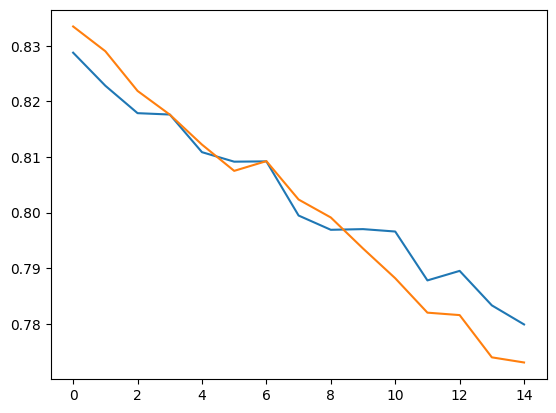

In [2]:
t = torch.load('./data_topo_accdim.pt')['reco_tracker'][:,:,-100:].mean(-1)
sp = torch.load('./data_sp_accdim.pt')['reco_tracker'][:,:,-100:].mean(-1) 
plt.plot(t[2])
plt.plot(sp[2])
t, sp

/tmp/ipykernel_76714/3782769042.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t = torch.load('./data_topo_accdim.pt')['se_pca_tracker']
/tmp/ipykernel_76714/3782769042

(tensor([[215., 155., 121.,  98.,  84.,  77.,  73.,  69.,  65.,  62.,  59.,  57.,
           55.,  53.,  51.],
         [309., 233., 192., 161., 143., 124., 112., 100.,  88.,  84.,  80.,  76.,
           74.,  72.,  70.],
         [368., 294., 242., 211., 184., 166., 153., 137., 128., 116., 110.,  98.,
           91.,  86.,  84.]]),
 tensor([[206., 171., 138.,  89.,  78.,  72.,  67.,  62.,  59.,  56.,  54.,  51.,
           51.,  47.,  46.],
         [274., 234., 186., 168., 143., 135., 122., 106.,  82.,  77.,  73.,  70.,
           68.,  65.,  63.],
         [330., 268., 220., 205., 178., 167., 158., 149., 135., 127., 115., 102.,
           99.,  88.,  82.]]))

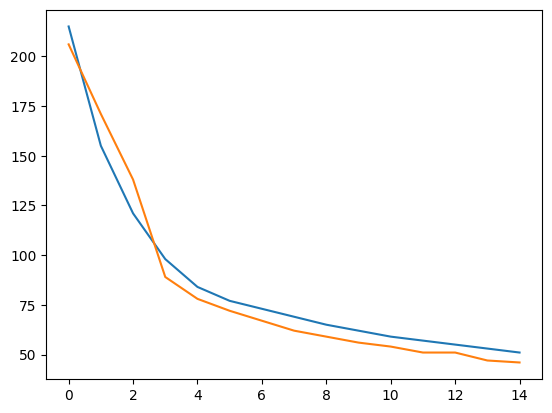

In [182]:
t = torch.load('./data_topo_accdim.pt')['se_pca_tracker']
sp = torch.load('./data_sp_accdim.pt')['se_pca_tracker'] 
plt.plot(t[0])
plt.plot(sp[0])
t, sp

In [618]:
batch_progress = tqdm(dataloader, leave=False)
trials = 20
samples = 100

scores = np.zeros((samples, trials, trials, trials))
vals = np.linspace(1, trials, trials)
vals = [8]
norms = np.linspace(1, 0.001, trials)
c = 0

a = 0

for b_idx, batch in enumerate(batch_progress):

    for image in batch:
    
        img = image[0:1][None].flip(1).cuda()
        model(img, adaptation=False, phi_long=1)
        dense = model.current_response.clone().cpu() + 0

        if dense[:,:,a:-a-1,a:-a-1].mean() > 0.01:
    
            for v_idx, v in enumerate(vals):

                for p_idx, p in enumerate(norms): 

                    model.lri_norm = np.exp(-v + 1) * 0.8 + 0.2
                    #model.mri_norm = p #np.exp(-v + 1) * 0.8 + 0.2
                    #model.sre_norm = np.exp(-v + 1) # p
                    
                    for pi_idx, pi in enumerate(norms): 

                        #model.sre_norm = np.exp(-v + 1)
                        model.lre_norm = np.exp(-v + 1) * 0.5 + 0.5
                        model.needs_update=True
                        o = 10
                        short_sparsity = (v + o - 1) / o
                        model(img, adaptation=False, phi_short=1, phi_mid=1, phi_long=v, noise_lvl=0., noise_temporal_corr=0.)
                        #plt.imshow(model.long_range_exc[1000,0].cpu())
                        #plt.show()
                        sparse = model.current_response.clone().cpu() + 0
                        scores[c, v_idx, p_idx, pi_idx] = cosim(dense[:,:,a:-a-1,a:-a-1], sparse[:,:,a:-a-1,a:-a-1])   
                        break
                    break

            c += 1
            print('image no. ' + str(c))

        if c == samples:
            break

    if c == samples:
        break

scores.mean(0).max(), short_sparsity

  0%|                                                  | 0/1209 [00:00<?, ?it/s]

0.5004559409827772 0.20072950557244362
image no. 1
image no. 2
image no. 3
image no. 4
image no. 5
image no. 6
image no. 7
image no. 8
image no. 9


  0%|                                          | 1/1209 [00:01<23:01,  1.14s/it]

image no. 10
image no. 11
image no. 12
image no. 13
image no. 14
image no. 15
image no. 16
image no. 17
image no. 18
image no. 19
image no. 20
image no. 21
image no. 22
image no. 23
image no. 24
image no. 25
image no. 26


  0%|                                          | 2/1209 [00:01<13:20,  1.51it/s]

image no. 27
image no. 28
image no. 29
image no. 30
image no. 31
image no. 32
image no. 33
image no. 34
image no. 35
image no. 36
image no. 37
image no. 38
image no. 39
image no. 40
image no. 41
image no. 42
image no. 43


  0%|                                          | 3/1209 [00:01<11:25,  1.76it/s]

image no. 44
image no. 45
image no. 46
image no. 47
image no. 48
image no. 49
image no. 50
image no. 51
image no. 52
image no. 53
image no. 54
image no. 55
image no. 56
image no. 57
image no. 58
image no. 59
image no. 60
image no. 61


  0%|▏                                         | 4/1209 [00:02<10:26,  1.92it/s]

image no. 62
image no. 63
image no. 64
image no. 65
image no. 66
image no. 67
image no. 68
image no. 69
image no. 70
image no. 71
image no. 72
image no. 73
image no. 74
image no. 75
image no. 76
image no. 77
image no. 78
image no. 79


  0%|▏                                         | 5/1209 [00:02<09:38,  2.08it/s]

image no. 80
image no. 81
image no. 82
image no. 83
image no. 84
image no. 85
image no. 86
image no. 87
image no. 88
image no. 89
image no. 90
image no. 91
image no. 92
image no. 93
image no. 94
image no. 95
image no. 96
image no. 97


image no. 98
image no. 99
image no. 100


(np.float64(0.9493407815694809), 1.7)

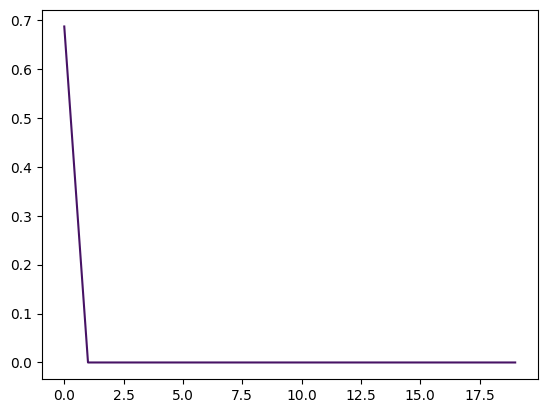

In [454]:
plt.plot(scores[:,0,0].mean(0))

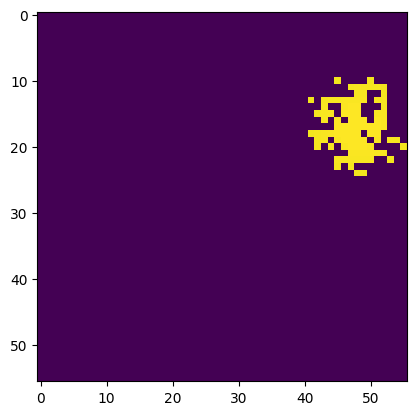

In [579]:
plt.imshow(model.short_range_exc[1000,0].cpu())
plt.show()

In [280]:
scores.mean(0).max(), scores.mean(0)[0,:,0], scores.mean(0)[0,:,0].argmax(), norms[scores.mean(0)[0,:,0].argmax()], scores[scores>0]

(np.float64(0.9341648757457733),
 array([0.79278973, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 np.int64(0),
 np.float64(1.0),
 array([0.76124239, 0.76440781, 0.77060831, 0.78592217, 0.78936028,
        0.79743582, 0.81159055, 0.82697135, 0.84092969, 0.85393953,
        0.86654508, 0.88219506, 0.90570837, 0.93281084, 0.9398551 ,
        0.91937912, 0.87860167, 0.83730578, 0.79555035, 0.75091672,
        0.78876907, 0.79208726, 0.79607725, 0.8012017 , 0.80505419,
        0.81055725, 0.81304204, 0.81418741, 0.81532228, 0.81146693,
        0.81536961, 0.83374465, 0.8675108 , 0.90245908, 0.91228968,
        0.90714091, 0.88229644, 0.84302115, 0.80400306, 0.76665556,
        0.78911334, 0.79237688, 0.79585969, 0.80005985, 0.8056156 ,
        0.81275833, 0.82561684, 0.84834433, 0.860

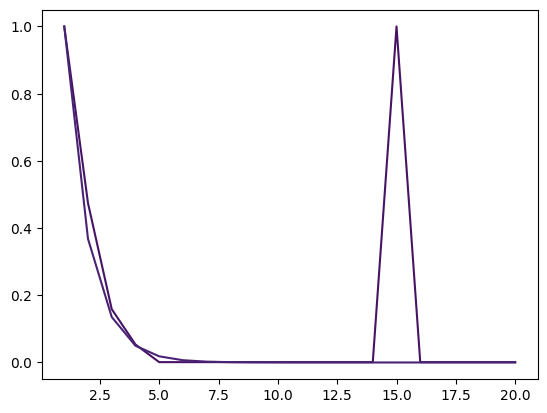

In [580]:
best = scores.mean(0)[:,:,0].argmax(1)
plt.plot(vals, norms[best])
fit = np.exp(-vals + 1)
plt.plot(vals, fit)

In [3]:
data = torch.load('data.pt')

/tmp/ipykernel_6617/3790423930.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('data.pt')


In [263]:
lr = 3e-4

In [1275]:
model.range_norm = 0.32

In [129]:
model.envelope = generate_gaussians(model.sheet_size, model.sheet_size, model.R_long/0.7, offset=model.window//2).to(model.device) * model.long_cutoff

In [614]:
### Looping over the DataLoader

trials = 15
trialvar = np.sqrt(np.linspace(20**2, 20**2, trials))
sizesvar = np.round(np.sqrt(np.linspace(400, 2500, 3))).astype(int)
sizesvar = [40]
sizes = len(sizesvar)
trials = len(trialvar)
noise = np.linspace(0., 0.6, trials)
print(trialvar, sizesvar, noise)
epochs = 10
reco_tracker = torch.zeros((sizes, trials, len(dataloader)))
se_tracker = torch.zeros((sizes, trials))
map_tracker = torch.zeros((sizes, trials, sizesvar[-1], sizesvar[-1]))
spectrum_tracker = torch.zeros((sizes, trials, sizesvar[-1], sizesvar[-1]))
peak_tracker = torch.zeros((sizes, trials))

tuning_curve_tracker = torch.zeros((sizes, trials, 101))
n_samples = 3
comp_tracker = torch.zeros((sizes, trials, n_samples*sizesvar[-1], n_samples*sizesvar[-1]))
se_pca_tracker = torch.zeros((sizes, trials))

gc.collect()


for s in range(sizes):
    for t in range(trials):
    
        KEEP = False
        if not KEEP:
            model = NeuralSheet(sizesvar[s], crop_size, R_rf, R_long=trialvar[t], device=device).to(device)
            lr = 1e-3
    
            network = init_nn(sizesvar[s], crop_size)
            avg_loss = 0

        code_tracker = []
        
        for e in range(epochs):

            batch_progress = tqdm(dataloader, leave=False)
            for b_idx, batch in enumerate(batch_progress):

                model.update_interactions(1,1,1)

                batch_responses = []
                batch_inputs = []
                batch = batch.to('cuda')  # Transfer the entire batch to GPU

                for image in batch:

                    image = image[0:1][None].flip(1)

                    if image.mean()>0.15:

                        limit = 2e-4
                        lr *= beta
                        lr = lr if lr>limit else limit
                        
                        model.hebbian_lr = lr
                        model.homeo_lr = lr

                        model(image, noise_lvl=0.)
                        model.hebbian_step()
                        
                        
                        batch_responses.append(model.current_response.clone())
                        batch_inputs.append(model.current_input.clone())
                        code_tracker.append(model.current_response.clone())

                batch_responses = torch.cat(batch_responses, dim=0)
                batch_inputs = torch.cat(batch_inputs, dim=0)

                reco_input = network['activ'](network['model'](batch_responses))

                targets = batch_inputs
                loss, loss_std = nn_loss(network, targets, reco_input)
                
                sim = cosim(targets.detach().cpu(), reco_input.detach().cpu(), True)
                reco_tracker[s, t, b_idx] = sim
                                
                avg_loss = (1-loss_beta)*avg_loss + loss_beta*sim
                
                network['optim'].zero_grad()
                loss.backward()
                network['optim'].step()
                
                if b_idx%50==0:
                    ori_map, phase_map, mean_tc = get_orientations(model.afferent_weights, gabor_size=model.rf_size)

                mean_activation = model.mean_activations.mean()
                mean_std = model.mean_activations.std() / model.homeo_target
                p = (model.avg_hist / model.avg_hist.sum())
                entropy = -(torch.log(p + 1e-11) * p).sum()

                #avg_aff = avg_aff * 0.99 + model.ap.mean() * 0.01
                
                batch_progress.set_description('M:{:.3f} STD:{:.3f} BCE:{:.3f} LR:{:.5f} SP:{:.3f} B:{:.3f} G:{:.3f} P:{:.3f} H:{:.3f}'.format(
                    mean_activation, 
                    mean_std, 
                    avg_loss,
                    lr,
                    model.spread.mean(),
                    model.b.mean(),
                    model.radial_b,
                    model.aff_strength,
                    entropy
                ))


[20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.] [40] [0.         0.04285714 0.08571429 0.12857143 0.17142857 0.21428571
 0.25714286 0.3        0.34285714 0.38571429 0.42857143 0.47142857
 0.51428571 0.55714286 0.6       ]


KeyboardInterrupt: 

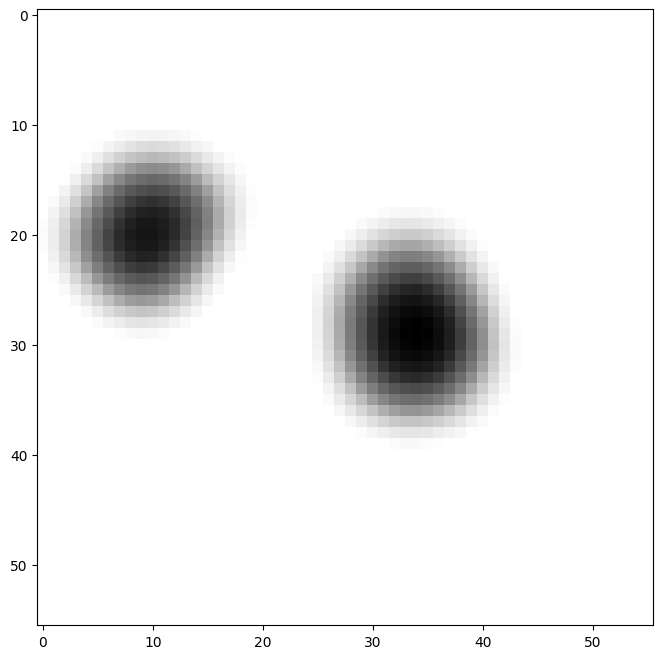

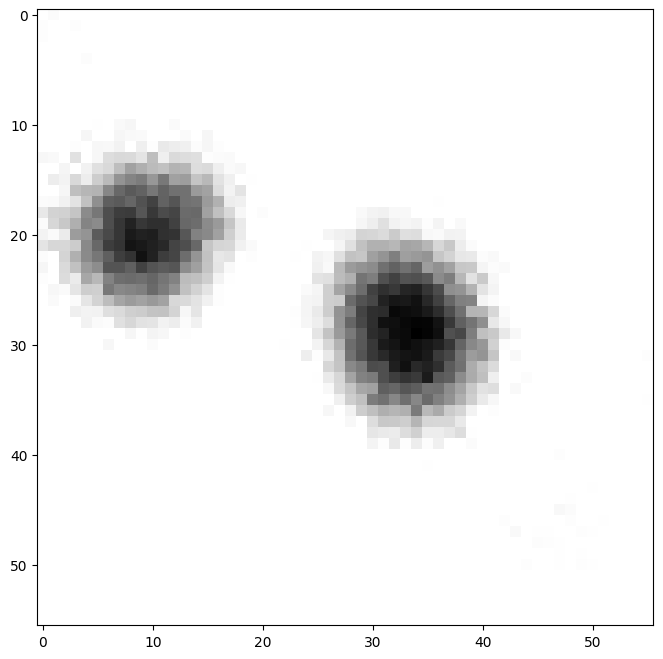

tensor(0.9897)

In [563]:
%matplotlib inline

#random_batch = random.randint(0, batch.shape[0] - 1)
image = batch[random_batch, 0:1][None].flip(1).cuda()

model(image, adaptation=False)
plt.figure(figsize=(8,8))
a = model.current_response[0,0].cpu()
plt.imshow(a, cmap=cm.Greys)
plt.show()

model(image, adaptation=False, phi_long=1, phi_short=1, noise_lvl=0., phi_mid=10)
plt.figure(figsize=(8,8))
b = model.current_response[0,0].cpu()
plt.imshow(b, cmap=cm.Greys)
plt.show()

cosim(a[None,None],b[None,None])

In [329]:
%matplotlib inline
plot_long_sparsification(model.long_range_exc, masks=model.long_sparsity_masks)

RuntimeError: The size of tensor a (60) must match the size of tensor b (80) at non-singleton dimension 3

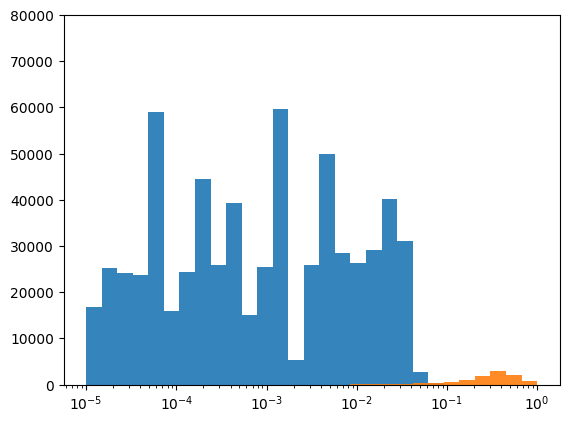

tensor(0.3801, device='cuda:0')

In [84]:
a = model.long_range_exc
a /= a.sum([2,3],keepdim=True)
masks = get_sparsity_masks(a, model.long_cutoff, 0.01)
p = find_norm_p(a, masks).cuda()
a_norm = a**1
a_norm /= (a_norm*masks).sum([2,3], keepdim=True)
a_norm_flat = a_norm[masks.bool()]
bins = np.logspace(-5, 0, 30)
plt.hist(a[a>0].flatten().cpu(), bins=bins, alpha=0.9)
plt.hist(a_norm_flat.cpu(), bins=bins, alpha=0.9)
plt.xscale('log')
plt.ylim(0, 8e4)
plt.show()
p.mean()

torch.Size([32, 3, 20, 20])
Net Afferent Max: -0.158, Net Afferent Min: -0.363
L4 Thresholds Max: 0.380, L4 Thresholds Min: 0.292
Mean current response: 0.000
L4 Strength: 2.000 aff strength: 0.298
Reco loss: 0.064%


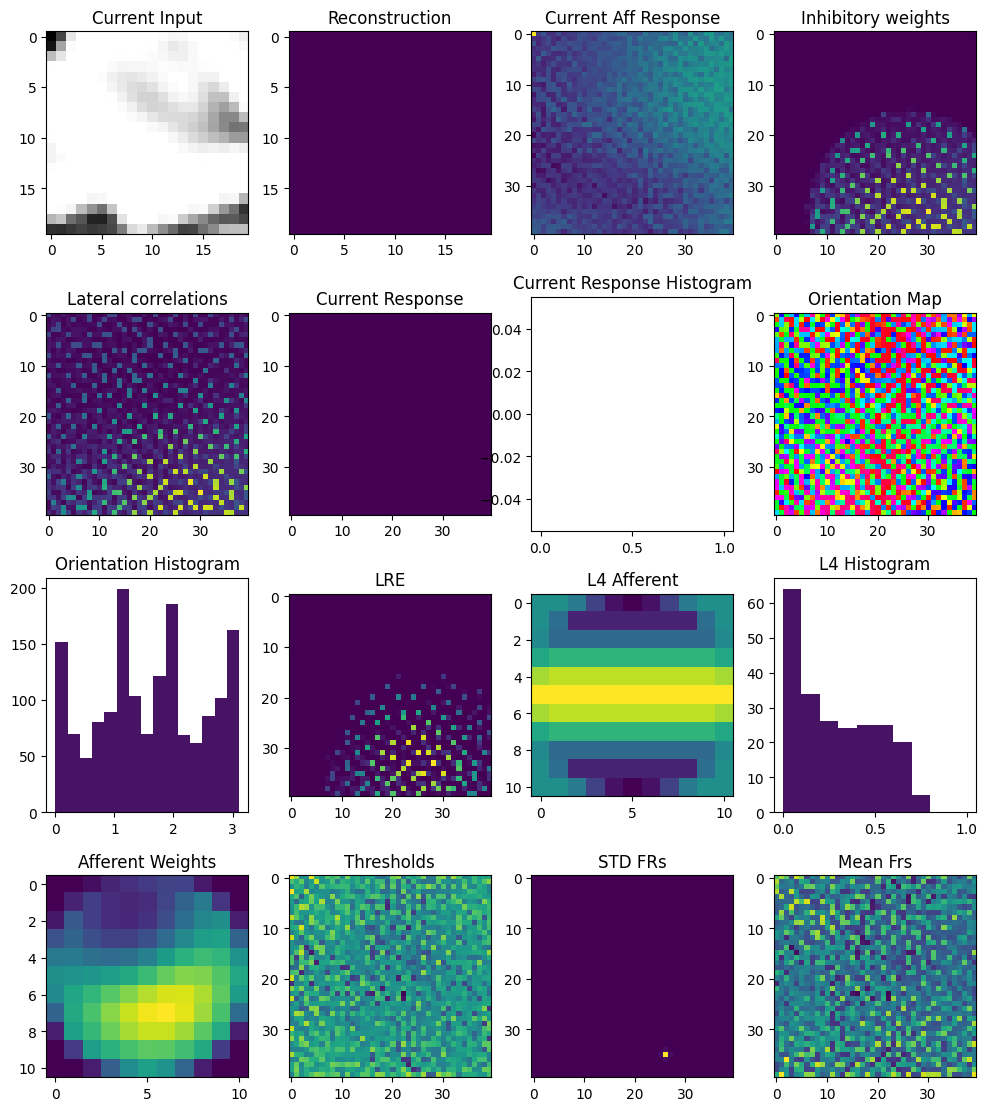

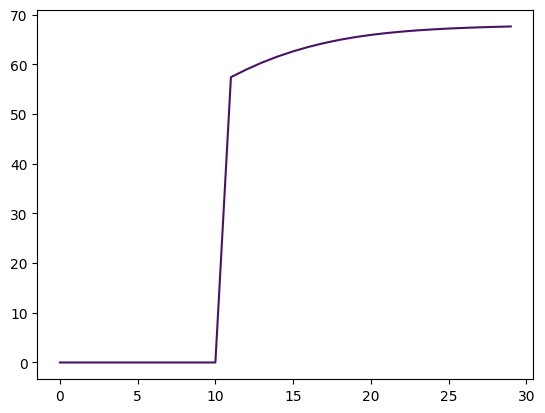

In [615]:
%matplotlib inline
#model.update_interactions(1,1,1)
random_sample = random.randint(0, model.afferent_weights.shape[0] - 1)
random_batch = random.randint(0, batch.shape[0] - 1)
print(batch.shape)

#%lprun -f model.forward model.forward(batch[random_batch, 0:1][None].flip(1),rf_grids)
model.forward(batch[random_batch, 0:1][None].flip(1).cuda(), performance_mode=False, noise_lvl=0., noise_temporal_corr=0., phi_long=1, phi_short=1.)
show_map(model, network, random_sample)
model.current_response.max()
array = model.response_tracker.cpu()[:,0]
array[:,0,0] = 1
anim = animate(array, model.iterations)
plt.plot(model.response_tracker[:model.iterations].sum([1,2,3]).cpu())
anim

/tmp/ipykernel_7150/1207509397.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('./data_sp_backup.pt')['noise_rob']
/tmp/ipykernel_7150/2518182998.py:21

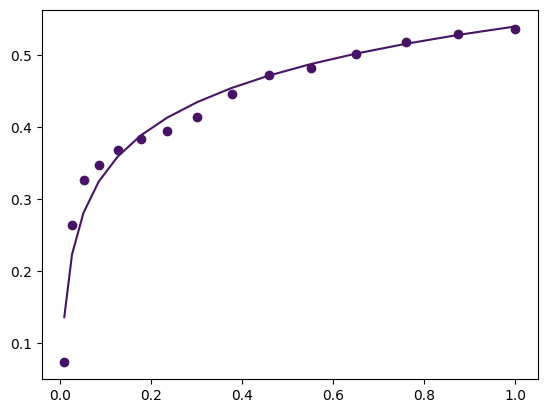

(np.float64(0.08777708447634422), np.float64(0.5401178115674772))

In [62]:
data = torch.load('./data_sp_backup.pt')['noise_rob']
data.shape
max_noise_topo = torch.tensor([find_val_loc(item, 0.95) for item in data[-1, :]])
max_noise_topo = max_noise_topo * 1 / 10
x = np.linspace(0.1,1,max_noise_topo.shape[0])**2
plt.scatter(x, max_noise_topo)

def log_fit(x, a,b):
    return a*np.log(x) + b

popt = curve_fit(log_fit,  x, max_noise_topo)[0]
popt = exact_log_fit(x, max_noise_topo)

plt.plot(x, log_fit(x, popt[0], popt[1]))
plt.show()
popt

In [22]:
ori_map, phase_map, mean_tc = get_orientations(model.afferent_weights, gabor_size=model.rf_size)
ori_map = ori_map.view(70,70).cpu()
count, pinwheels, pinwheels_copy = count_pinwheels(ori_map, avg_peak)
plt.imshow(pinwheels_copy)
plt.show()
plt.imshow(pinwheels), peak, count, count / 70**2 * avg_peak**2, avg_peak

RuntimeError: shape '[70, 70]' is invalid for input of size 3600

In [35]:
make_fig1_plots(torch.load('./data_sp.pt'), torch.load('./data_topo.pt'))

/tmp/ipykernel_4933/1843400429.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  make_fig1_plots(torch.load('./data_sp.pt'), torch.load('./data_topo.pt'))


In [7]:
torch.load('./data_sp.pt')['sparsity_rob']

/tmp/ipykernel_4933/558911398.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('./data_sp.pt')['sparsity_rob']


tensor([[[[1.0000, 0.8483, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000]],

         [[1.0000, 0.9147, 0.8886, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000]],

         [[1.0000, 0.9272, 0.9112, 0.8937, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000]],

         [[1.0000, 0.9348, 0.9183, 0.9054, 0.8925, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000]],

         [[1.0000, 0.9378, 0.9204, 0.9099, 0.9009, 0.8931, 0.0000, 0.0000,
           0.0000, 0.0000]],

         [[1.0000, 0.9460, 0.9341, 0.9237, 0.9141, 0.9084, 0.8985, 0.0000,
           0.0000, 0.0000]],

         [[1.0000, 0.9483, 0.9391, 0.9304, 0.9234, 0.9163, 0.9107, 0.9049,
           0.8982, 0.0000]],

         [[1.0000, 0.9422, 0.9330, 0.9254, 0.9205, 0.9151, 0.9097, 0.9041,
           0.8997, 0.0000]],

         [[1.0000, 0.9576, 0.9493, 0.9447, 0.9378, 0.9313, 0.9268, 0.9222,
           0.9154, 0.9131]],

         [[1.0000, 0.9547, 0.9492, 0.9445, 0.9405, 0.93

In [303]:
%matplotlib widget
sample = np.random.randint(0, model.sheet_size**2)
sample = 1751
EXP = 2
x = np.linspace(-1, 1, sizesvar[0]*EXP)
y = np.linspace(-1, 1, sizesvar[0]*EXP)
x, y = np.meshgrid(x, y)
z = model.lateral_correlations[sample,0].cpu()
z = z**(1)
z = F.interpolate(z[None][None], sizesvar[0]*EXP, mode='bicubic')[0,0]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.axis('off')


ax.plot_surface(x, y, z, cmap='Blues', edgecolor='none', rstride=1, cstride=1, alpha=1)
plt.show()

IndexError: index 1751 is out of bounds for dimension 0 with size 784

/tmp/ipykernel_9626/4074612758.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('data.pt')


(np.float64(-0.5), np.float64(59.5), np.float64(59.5), np.float64(-0.5))

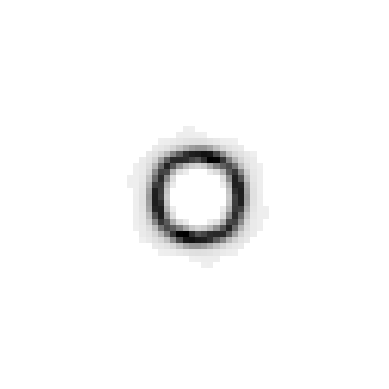

In [34]:
data = torch.load('data.pt')
c = data['comp_tracker']
s = data['spectrum_tracker']
plt.imshow(s[2,2], cmap=cm.Greys)
plt.axis('off')

In [177]:
plt.clf()
%matplotlib inline

num_samples = 100   # Number of samples you want to draw
theta = 0

# Assuming model.sheet_size and M are defined elsewhere
# model.sheet_size = ...  
M = model.sheet_size

#sample_idx = np.random.randint(0, model.sheet_size**2)
#z = model.lateral_correlations[sample_idx, 0].cpu()

# Generate an example distribution (MxM)
# This could be your actual distribution, ensure it sums to 1 if it represents probabilities
distribution = torch.relu(z - theta)
distribution /= distribution.sum()

sample_and_plot(distribution, num_samples, sample_idx, ori_map.view(60,60).cpu())

/home/nicolamendini/Desktop/topological_maps_are_for/map_plotting.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist_tensor = torch.tensor(distribution.flatten(), dtype=torch.float)


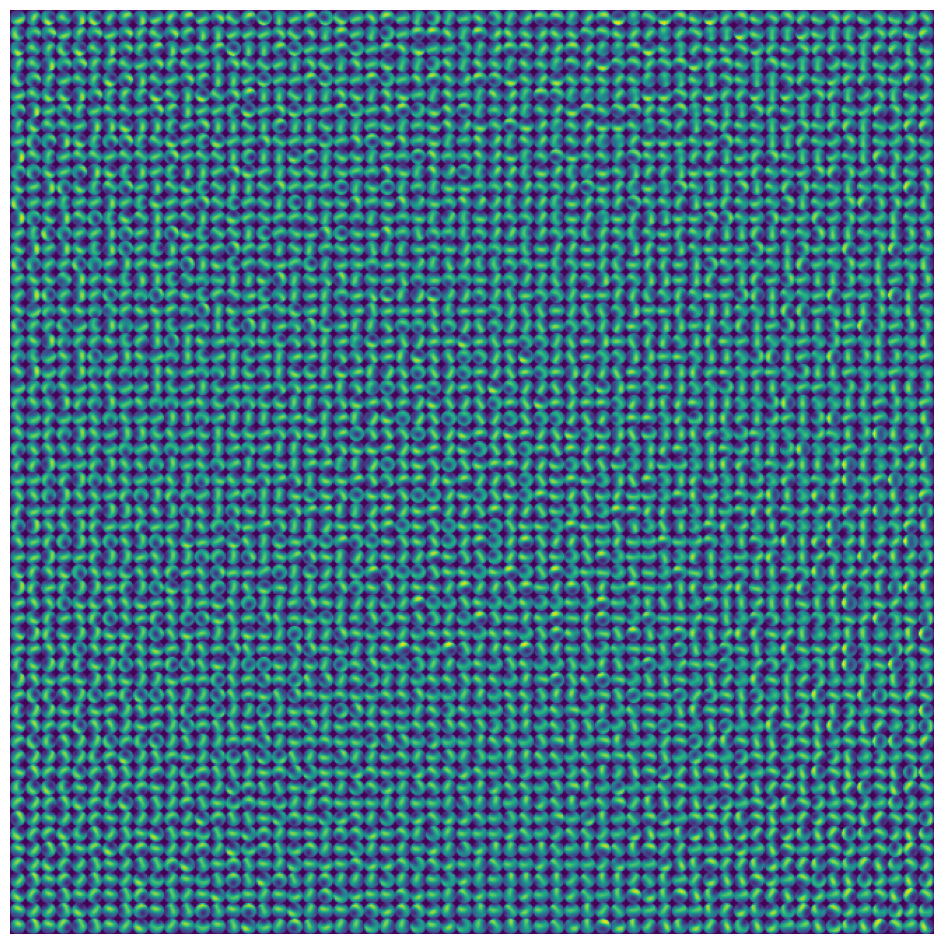

In [359]:
%matplotlib inline
angles = model.get_aff_weights().cpu()
angles = angles.view(model.sheet_size, model.sheet_size, model.rf_size, model.rf_size)
angles = angles.permute(0,2,1,3).reshape(model.sheet_size*model.rf_size, model.sheet_size*model.rf_size)
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(angles)

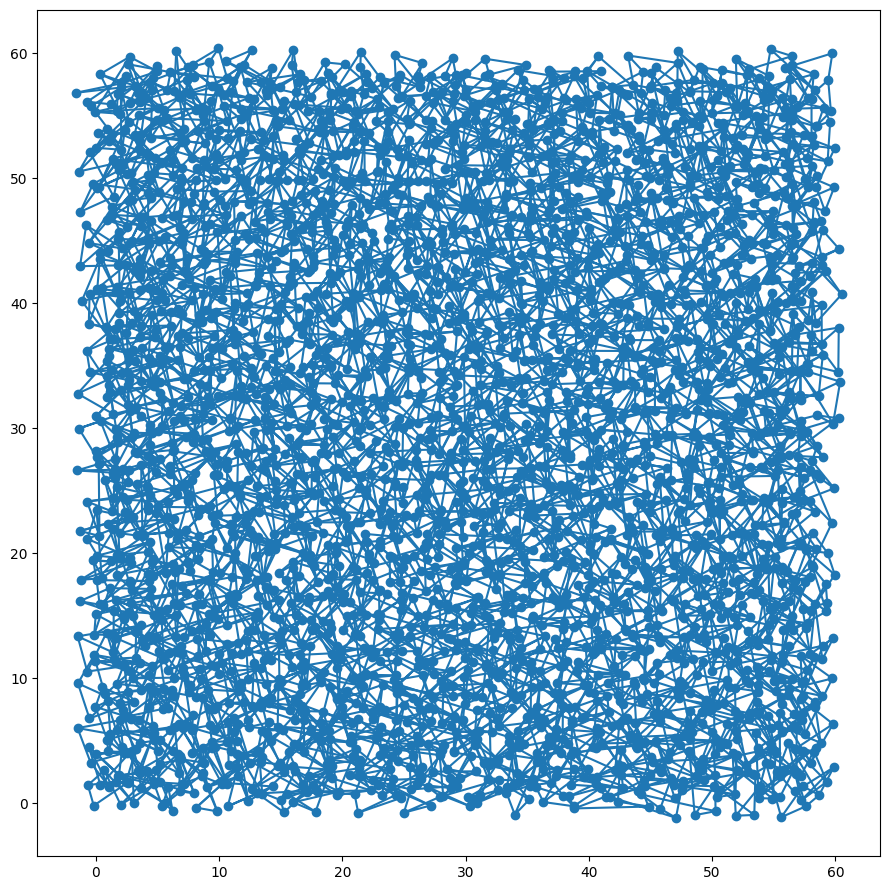

In [241]:
plot_absolute_phases(model)